In [70]:
# import libraries and frameworks!
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st 

import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.style.use('seaborn') # pretty matplotlib plots
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)


In [24]:
# This function extracts the interesting data columns for the given benchmark
# program and returns a dataframe with these columns.
def extract_data(benchmark):
    
    int_2006 = processors[processors[benchmark].notnull()]
    int_2006 = int_2006.reset_index(drop=True)
    perf = int_2006[benchmark]

    max_perf = max(int_2006[benchmark])
    min_perf = min(int_2006[benchmark])
    range_perf = max_perf - min_perf
    nperf = perf.apply(lambda x: 100*(x - min_perf) / range_perf)

    clock = int_2006["Processor Clock [MHz]"]
    threads = int_2006["Threads/core"]
    cores = int_2006["Cores"]
    TDP = int_2006["TDP"]
    transistors = int_2006["Transistors (millions)"]
    dieSize = int_2006["Die size (mm^2)"]
    voltage = int_2006["Voltage (low)"]
    featureSize = int_2006["Feature Size [microns]"]
    channel = int_2006["Channel length [microns]"]
    FO4delay = int_2006["FO4 Delay [ps]"]
    L1icache = int_2006["L1 (instruction) (on chip)"]
    L1dcache = int_2006["L1 (data) (on chip)"]
    L2cache = int_2006["L2 (on chip)"]
    L3cache = int_2006["L3 (on chip)"]

    data_frame = pd.DataFrame(dict(nperf= nperf, perf=perf, clock = clock, threads = threads, cores = cores, TDP = TDP,
                                transistors = transistors, dieSize = dieSize, voltage = voltage, featureSize = featureSize,
                                channel = channel, FO4delay = FO4delay, L1icache = L1icache, L1dcache = L1dcache,
                                L2cache = L2cache, L3cache = L3cache))
    return(data_frame)

In [25]:
 #read dataset
processors = pd.read_csv('all-data.csv',sep=",", header=0)

# extract data from a specific benchmark
cpu_info = extract_data("SpecInt2006 (average base)")

cpu_info.head()

,FO4delay,L1dcache,L1icache,L2cache,L3cache,TDP,channel,clock,cores,dieSize,featureSize,nperf,perf,threads,transistors,voltage
0,NaN,NaN,NaN,NaN,NaN,80.0,NaN,2400.0,4.0,NaN,NaN,51.341351,33.50,2.0,NaN,0.6
1,NaN,NaN,NaN,NaN,NaN,60.0,NaN,2000.0,6.0,NaN,NaN,55.596670,35.80,2.0,NaN,0.6
2,NaN,NaN,NaN,NaN,NaN,80.0,NaN,2200.0,4.0,NaN,NaN,46.160962,30.70,1.0,NaN,0.6
3,19.08,64.0,64.0,512.0,NaN,NaN,0.053,1200.0,1.0,NaN,0.09,0.000000,5.75,1.0,NaN,NaN
4,19.08,64.0,64.0,1024.0,NaN,110.0,0.053,2600.0,2.0,199.0,0.09,8.048104,10.10,1.0,233.0,1.3


## Project 2: Multiple regression

In multiple regression there is one variable to be forecast and several predictor variables.

- We want to forecast the performance of a CPU based on many factors determined by its architecture. Thus, we use the values of several predictor variables to estimate/predict this one variable (performance)

Instead of using the **Int2000** benchmark for the CPU performance reference, we will use the **Int2006** to differentiate from the book (chapter 4).

## Introduction to multiple regression

The general form of a multiple regression is 

$$
y_{i} = \beta_{0} + \beta_{1} x_{1,i} + \beta_{2} x_{2,i} + \cdots + \beta_{k} x_{k,i} + e_{i}, 
$$

where $y_{i}$ is the variable to be forecast and $x_{1,i},\dots,x_{k,i}$ are the $k$ predictor variables. 

The coefficients $\beta_{1},\dots,\beta_{k}$ measure the effect of each predictor after taking account of the effect of all other predictors in the model.

Thus, the coefficients measure the *marginal effects* of the predictor variables.

***

We first plot a pairwise comparison of all variables in the **Int2006** dataset:

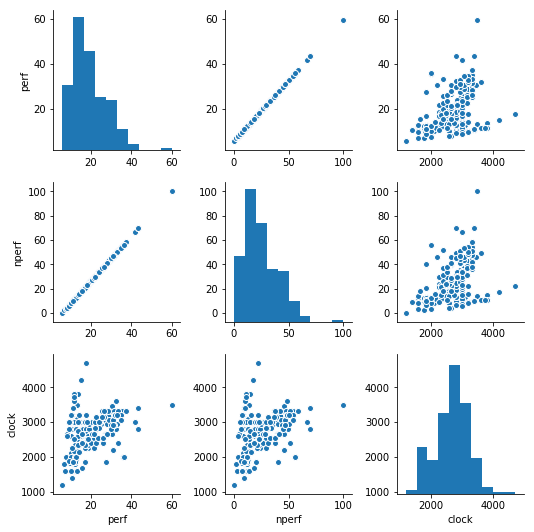

In [26]:
sns.pairplot(cpu_info[['perf', 'nperf',"clock"]])
plt.show()

We can observe the linear relationship between the *perf* and *nperf* (normalized performance) variables. We can also observe the same kind of relationship between the *clock* frequency and the *perf/nperf*.

The next step is to pick the minimum number of predictors that can give us a good prediction. As explained in the book, using all the factor is not the optimal method, as it leads to over-fitting. To decide which factors are best for using the model, the **Backward Elimination Process**.

## Backward Elimination Process

We use the *summary()* function to find each factor's significance level. We discard the factor with the highest significance level, until we reach to a factor with $p \lt 0.05$.


In [34]:
lr = smf.ols('nperf ~ clock + threads + cores + transistors + dieSize + voltage + featureSize + channel + FO4delay + L1icache + np.sqrt(L1icache) + L1dcache + np.sqrt(L1dcache) + L2cache + np.sqrt(L2cache)',data = cpu_info ).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  nperf   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     246.3
Date:                Wed, 25 Oct 2017   Prob (F-statistic):           5.25e-93
Time:                        14:47:09   Log-Likelihood:                -378.23
No. Observations:                 159   AIC:                             786.5
Df Residuals:                     144   BIC:                             832.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept          -191.6391     22.692     -8.445      0.000      -236.492  -146.786
clock                 0.0114      0.001     18.353      0.000         0.010     0.013
threads              -0.4371      0.592     -0.739      0.461        -1.606     0.732
cores                 0.5848      0.568      1.030      0.305        -0.538     1.707
transistors           0.0107      0.003      3.200      0.002         0.004     0.017
dieSize              -0.0124      0.009     -1.410      0.161        -0.030     0.005
voltage              -3.3710      2.512     -1.342      0.182        -8.336     1.594
featureSize        -325.1903     67.077     -4.848      0.000      -457.774  -192.607
channel             952.3161    310.837      3.064      0.003       337.924  1566.709
FO4delay             -0.8582      0.640     -1.340      0.182        -2.124     0.408
L1icache             -5.7416      1.148     -5.001      0.000        -8.011    -3.472
np.sqrt(L1icache)    32.1122      3.346      9.596      0.000        25.498    38.727
L1dcache              0.4787      0.684      0.700      0.485        -0.873     1.830
np.sqrt(L1dcache)    32.9456      3.567      9.236      0.000        25.895    39.996
L2cache               0.0027      0.000      7.991      0.000         0.002     0.003
np.sqrt(L2cache)     -0.4923      0.040    -12.371      0.000        -0.571    -0.414
==============================================================================
Omnibus:                        0.382   Durbin-Watson:                   1.351
Prob(Omnibus):                  0.826   Jarque-Bera (JB):                0.365
Skew:                           0.114   Prob(JB):                        0.833
Kurtosis:                       2.942   Cond. No.                     1.26e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.9e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

We remove $\sqrt{L1dcache}$, because of NA values and $threads$ because of the highest *p-value* ($p = 0.46116$).

In [35]:
lr = smf.ols('nperf ~ clock + cores + transistors + dieSize + voltage + featureSize + channel + FO4delay + L1icache + np.sqrt(L1icache) + L1dcache + L2cache + np.sqrt(L2cache)',data = cpu_info ).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  nperf   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     266.0
Date:                Wed, 25 Oct 2017   Prob (F-statistic):           4.13e-94
Time:                        15:01:56   Log-Likelihood:                -378.54
No. Observations:                 159   AIC:                             785.1
Df Residuals:                     145   BIC:                             828.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept          -189.6925     22.503     -8.429      0.000      -234.170  -145.215
clock                 0.0114      0.001     18.425      0.000         0.010     0.013
cores                 0.7373      0.528      1.396      0.165        -0.307     1.781
transistors           0.0103      0.003      3.130      0.002         0.004     0.017
dieSize              -0.0130      0.009     -1.481      0.141        -0.030     0.004
voltage              -3.3357      2.508     -1.330      0.186        -8.292     1.620
featureSize        -321.0888     66.743     -4.811      0.000      -453.003  -189.175
channel             927.7025    308.563      3.007      0.003       317.841  1537.564
FO4delay             -0.8104      0.636     -1.274      0.205        -2.068     0.447
L1icache             -9.9432      1.581     -6.288      0.000       -13.068    -6.818
np.sqrt(L1icache)    64.1783      6.799      9.440      0.000        50.741    77.616
L1dcache              4.7525      1.094      4.346      0.000         2.591     6.914
L2cache               0.0027      0.000      8.202      0.000         0.002     0.003
np.sqrt(L2cache)     -0.4939      0.040    -12.446      0.000        -0.572    -0.415
==============================================================================
Omnibus:                        0.309   Durbin-Watson:                   1.351
Prob(Omnibus):                  0.857   Jarque-Bera (JB):                0.316
Skew:                           0.103   Prob(JB):                        0.854
Kurtosis:                       2.928   Cond. No.                     7.75e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.75e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Then we remove the $FO4delay$ factor:


In [36]:
lr = smf.ols('nperf ~ clock + cores + transistors + dieSize + voltage + featureSize + channel + L1icache + np.sqrt(L1icache) + L1dcache + L2cache + np.sqrt(L2cache)',data = cpu_info ).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  nperf   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     286.9
Date:                Wed, 25 Oct 2017   Prob (F-statistic):           5.33e-95
Time:                        15:03:10   Log-Likelihood:                -379.42
No. Observations:                 159   AIC:                             784.8
Df Residuals:                     146   BIC:                             824.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept          -190.8422     22.533     -8.469      0.000      -235.376  -146.309
clock                 0.0112      0.001     18.687      0.000         0.010     0.012
cores                 0.8468      0.522      1.621      0.107        -0.185     1.879
transistors           0.0098      0.003      2.979      0.003         0.003     0.016
dieSize              -0.0111      0.009     -1.283      0.202        -0.028     0.006
voltage              -3.2514      2.512     -1.294      0.198        -8.216     1.713
featureSize        -259.6825     46.265     -5.613      0.000      -351.118  -168.247
channel             540.7694     54.587      9.907      0.000       432.886   648.652
L1icache             -9.9422      1.585     -6.274      0.000       -13.074    -6.811
np.sqrt(L1icache)    64.9537      6.786      9.572      0.000        51.543    78.365
L1dcache              4.6562      1.093      4.259      0.000         2.495     6.817
L2cache               0.0026      0.000      8.151      0.000         0.002     0.003
np.sqrt(L2cache)     -0.4761      0.037    -12.792      0.000        -0.550    -0.403
==============================================================================
Omnibus:                        0.025   Durbin-Watson:                   1.324
Prob(Omnibus):                  0.987   Jarque-Bera (JB):                0.026
Skew:                          -0.019   Prob(JB):                        0.987
Kurtosis:                       2.949   Cond. No.                     1.59e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Consequently, we remove the $dieSize$ factor ($p=0.202$):

In [37]:
lr = smf.ols('nperf ~ clock + cores + transistors + voltage + featureSize + channel + L1icache + np.sqrt(L1icache) + L1dcache + L2cache + np.sqrt(L2cache)',data = cpu_info ).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  nperf   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     311.4
Date:                Wed, 25 Oct 2017   Prob (F-statistic):           6.67e-96
Time:                        15:04:14   Log-Likelihood:                -380.31
No. Observations:                 159   AIC:                             784.6
Df Residuals:                     147   BIC:                             821.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept          -194.3426     22.417     -8.670      0.000      -238.643  -150.042
clock                 0.0111      0.001     18.602      0.000         0.010     0.012
cores                 0.5357      0.464      1.155      0.250        -0.380     1.452
transistors           0.0071      0.003      2.801      0.006         0.002     0.012
voltage              -2.6826      2.478     -1.083      0.281        -7.580     2.215
featureSize        -299.4033     34.454     -8.690      0.000      -367.492  -231.315
channel             549.3682     54.293     10.119      0.000       442.073   656.664
L1icache            -10.3245      1.560     -6.619      0.000       -13.407    -7.242
np.sqrt(L1icache)    66.5852      6.680      9.967      0.000        53.383    79.787
L1dcache              4.9102      1.078      4.557      0.000         2.781     7.040
L2cache               0.0027      0.000      8.467      0.000         0.002     0.003
np.sqrt(L2cache)     -0.4801      0.037    -12.917      0.000        -0.554    -0.407
==============================================================================
Omnibus:                        0.234   Durbin-Watson:                   1.354
Prob(Omnibus):                  0.890   Jarque-Bera (JB):                0.052
Skew:                           0.021   Prob(JB):                        0.974
Kurtosis:                       3.078   Cond. No.                     1.50e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We remove the $voltage$ factor ($p=0.281$):

In [39]:
lr = smf.ols('nperf ~ clock + cores + transistors + featureSize + channel + L1icache + np.sqrt(L1icache) + L1dcache + L2cache + np.sqrt(L2cache)',data = cpu_info ).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  nperf   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     294.2
Date:                Wed, 25 Oct 2017   Prob (F-statistic):           1.63e-94
Time:                        15:04:56   Log-Likelihood:                -406.03
No. Observations:                 164   AIC:                             834.1
Df Residuals:                     153   BIC:                             868.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept          -197.9280     19.999     -9.897      0.000      -237.438  -158.418
clock                 0.0113      0.001     17.545      0.000         0.010     0.013
cores                 0.8770      0.455      1.926      0.056        -0.023     1.777
transistors           0.0071      0.002      2.903      0.004         0.002     0.012
featureSize        -294.3015     36.288     -8.110      0.000      -365.991  -222.612
channel             482.1255     56.180      8.582      0.000       371.136   593.115
L1icache            -10.2990      1.507     -6.835      0.000       -13.276    -7.322
np.sqrt(L1icache)    66.7223      6.100     10.939      0.000        54.672    78.773
L1dcache              4.8914      1.072      4.564      0.000         2.774     7.009
L2cache               0.0025      0.000      7.256      0.000         0.002     0.003
np.sqrt(L2cache)     -0.4490      0.039    -11.467      0.000        -0.526    -0.372
==============================================================================
Omnibus:                       12.169   Durbin-Watson:                   1.332
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.577
Skew:                           0.514   Prob(JB):                     0.000683
Kurtosis:                       4.037   Cond. No.                     1.47e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Finally, we remove the $cores$ factor that has a marginally high p-value significance value:

In [41]:
lr = smf.ols('nperf ~ clock + transistors + featureSize + channel + L1icache + np.sqrt(L1icache) + L1dcache + L2cache + np.sqrt(L2cache)',data = cpu_info ).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  nperf   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     320.9
Date:                Wed, 25 Oct 2017   Prob (F-statistic):           5.49e-95
Time:                        15:05:44   Log-Likelihood:                -407.99
No. Observations:                 164   AIC:                             836.0
Df Residuals:                     154   BIC:                             867.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept          -221.8915     15.793    -14.050      0.000      -253.091  -190.692
clock                 0.0107      0.001     18.757      0.000         0.010     0.012
transistors           0.0109      0.001      7.537      0.000         0.008     0.014
featureSize        -293.3727     36.602     -8.015      0.000      -365.680  -221.066
channel             488.2855     56.580      8.630      0.000       376.512   600.059
L1icache            -12.2919      1.105    -11.124      0.000       -14.475   -10.109
np.sqrt(L1icache)    74.6448      4.543     16.431      0.000        65.670    83.619
L1dcache              6.3008      0.790      7.977      0.000         4.740     7.861
L2cache               0.0025      0.000      7.272      0.000         0.002     0.003
np.sqrt(L2cache)     -0.4532      0.039    -11.493      0.000        -0.531    -0.375
==============================================================================
Omnibus:                       11.689   Durbin-Watson:                   1.360
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               15.955
Skew:                           0.436   Prob(JB):                     0.000343
Kurtosis:                       4.254   Cond. No.                     1.47e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We don't have to remove any more factors, as the $p-values$ for all the predictors is far less than $0.05$. The factors we use for developing the multi-factor linear regression model are the *clock, transistors, featureSize, channel, L1icache, $\sqrt{L1icache}$, L1dcache, L2cache, $\sqrt{L2cache}$*. The final estimator model is:

$$nperf = 
-221.89 + 0.0107\times clock + 0.0109\times transistors - 293.4\times featureSize + \\
488.3\times channel -12.29\times L1icache + 74.64\times \sqrt{L1icache} \\
+ 6.301 \times L1dcache + 0.0025 \times L2cache -0.4532 \times \sqrt{L2cache}$$

The $R^2$ value is very close to $1$, which means that our estimation is pretty good. Furthermore, fewer observations have been dropped (due to NA values), because now we use fewer factors for the model estimator. These two observation show that our estimator behaves very good!

## Residual Analysis

We apply the *Residual Analysis* technique, to examine our model: 

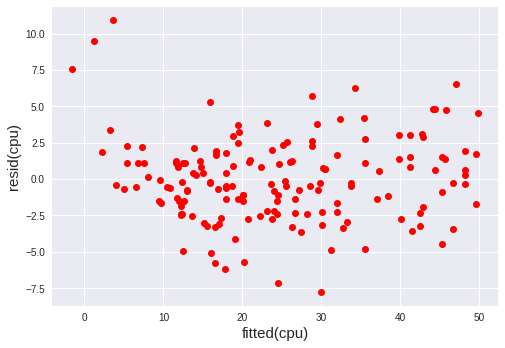

In [53]:
# fitted values
cpu_fitted = lr.fittedvalues

# model residuals
cpu_residuals = lr.resid

plt.plot(cpu_fitted,cpu_residuals,'ro')
plt.ylabel('resid(cpu)')
plt.xlabel('fitted(cpu)')
plt.show()


We can see that the residuals are distributed somewhat uniformly around the mean value, which is almost zero. No obvious patterns are visible, which means that the residuals are not well behaved. Below, we plot the histogram of the residual's distribution, which verifies that our model is not poor.


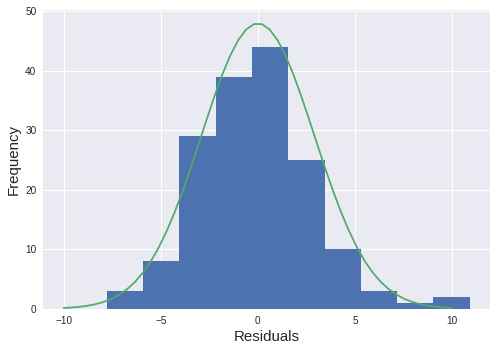

In [68]:
#plot histogram
plt.hist(cpu_residuals)
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Plot normal distribution
x = np.linspace(-10, 10)
plt.plot(x,350*st.norm.pdf(x, 0, np.std(cpu_residuals,axis=0)))
plt.show()

Finally, by plotting a *Q-Q plot*,  we can see that the residuals almost follow a normal distribution, especially in the center. There is a visible divergence in both ends, although this applies to very few points. 

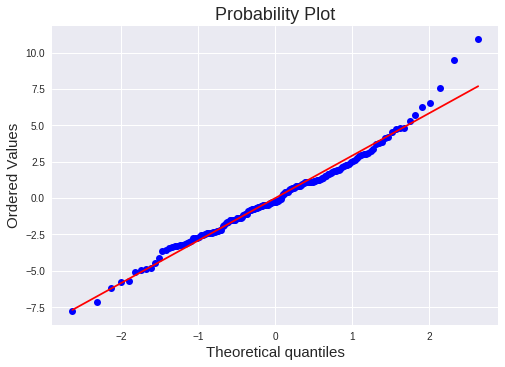

In [78]:
st.probplot(cpu_residuals, dist="norm", plot=plt)
plt.show()